In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
# Global list to store DataFrame names
df_names = []


In [ ]:
# Decorator to track DataFrame creation
def track_dataframe(func):
    def wrapper(*args, **kwargs):
        # Get the result of the function (which should be a DataFrame)
        result = func(*args, **kwargs)
        
        # Add the name of the DataFrame to df_names list
        # If the DataFrame does not have a name attribute, use the function's name as a placeholder
        name = getattr(result, 'name', func.__name__)
        df_names.append(name)
        
        return result
    return wrapper

In [ ]:
# Example of usage:
@track_dataframe
def create_example_df():
    import pandas as pd
    df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
    return df

# Call the function to test the decorator
example_df = create_example_df()

# Display the df_names list
df_names

In [5]:
# List the contents of the extraction directory
extraction_dir = "src/"
files = os.listdir(extraction_dir)
files

['Best Movie by Year Netflix.csv',
 'Best Movies Netflix.csv',
 'Best Show by Year Netflix.csv',
 'Best Shows Netflix.csv',
 'raw_credits.csv',
 'raw_titles.csv']

# raw_titles

In [7]:
# Load the raw_titles.csv file
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Display the first few rows of the dataframe
raw_titles_df.head()


,index,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
0,0,ts300399,Five Came Back: The Reference Films,SHOW,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN
1,1,tm84618,Taxi Driver,MOVIE,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0
2,2,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0
3,3,tm70993,Life of Brian,MOVIE,1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0
4,4,tm190788,The Exorcist,MOVIE,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0


In [8]:
# Check for missing values in the raw_titles dataframe
missing_values = raw_titles_df.isnull().sum()
missing_values_percentage = (raw_titles_df.isnull().sum() / len(raw_titles_df)) * 100

# Combine the counts and percentages into a dataframe for a clearer view
missing_values_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percentage
}).sort_values(by='Percentage (%)', ascending=False)

missing_values_df


,Missing Values,Percentage (%)
seasons,3759,64.743369
age_certification,2610,44.953496
imdb_votes,539,9.283500
imdb_score,523,9.007923
imdb_id,444,7.647261
title,1,0.017224
index,0,0.000000
id,0,0.000000
type,0,0.000000
release_year,0,0.000000


In [ ]:
"""seasons (64.74% missing): This is expected, as the seasons column would primarily apply to TV shows, and not all entries in the dataset are TV shows.
age_certification (44.95% missing): Almost half of the titles lack age certification data.
imdb_votes (9.28% missing): A minor percentage of titles don't have the number of IMDB votes.
imdb_score (9.01% missing): Similarly, a small percentage of titles don't have IMDB scores.
imdb_id (7.65% missing): Some titles don't have their corresponding IMDB IDs.
title (0.02% missing): Only one title is missing its name."""

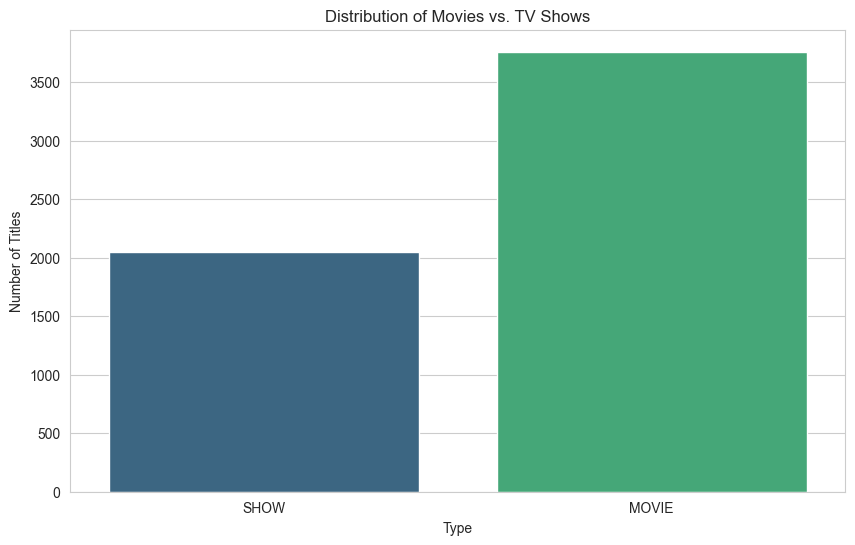

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of Movies vs. TV Shows
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=raw_titles_df, palette='viridis')
plt.title('Distribution of Movies vs. TV Shows')
plt.ylabel('Number of Titles')
plt.xlabel('Type')
plt.show()

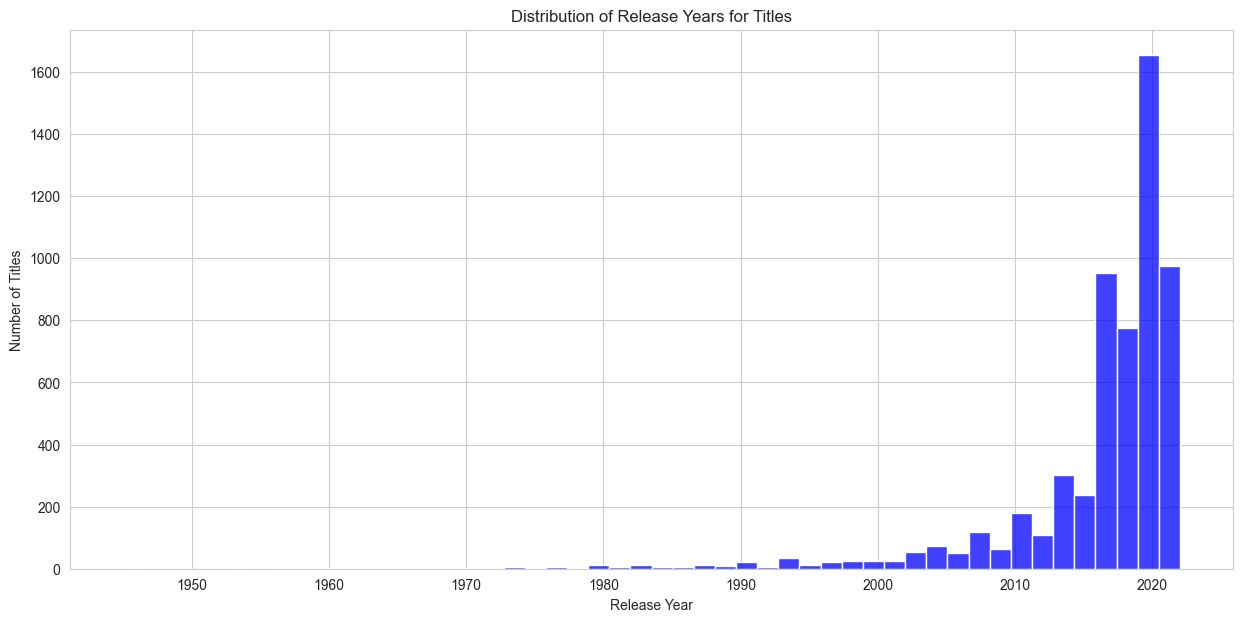

In [17]:
# Plot the distribution of release years for titles
plt.figure(figsize=(15, 7))
sns.histplot(raw_titles_df['release_year'], kde=False, bins=50, color='blue')
plt.title('Distribution of Release Years for Titles')
plt.ylabel('Number of Titles')
plt.xlabel('Release Year')
plt.show()

"""The dataset predominantly contains titles released from the early 2000s onwards, with a peak around the 2010s. There are fewer titles from the mid-20th century, and the number increases gradually from the 1980s.
"""


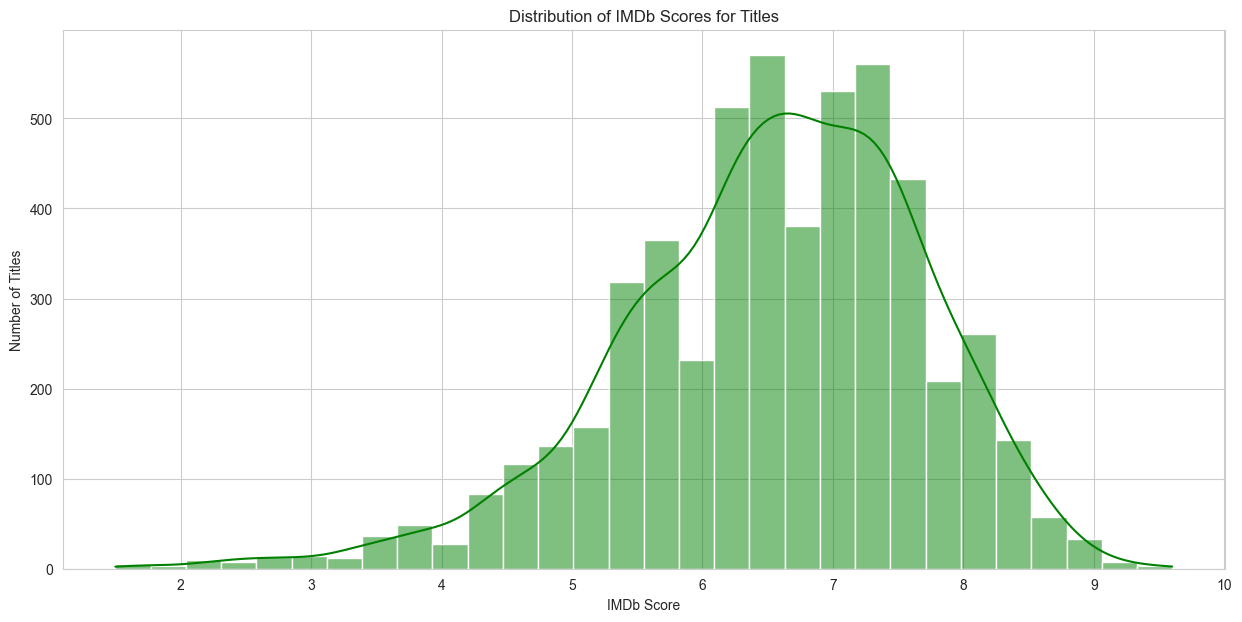

In [18]:
# Plot the distribution of IMDb scores for titles
plt.figure(figsize=(15, 7))
sns.histplot(raw_titles_df['imdb_score'].dropna(), kde=True, bins=30, color='green')
plt.title('Distribution of IMDb Scores for Titles')
plt.ylabel('Number of Titles')
plt.xlabel('IMDb Score')
plt.show()


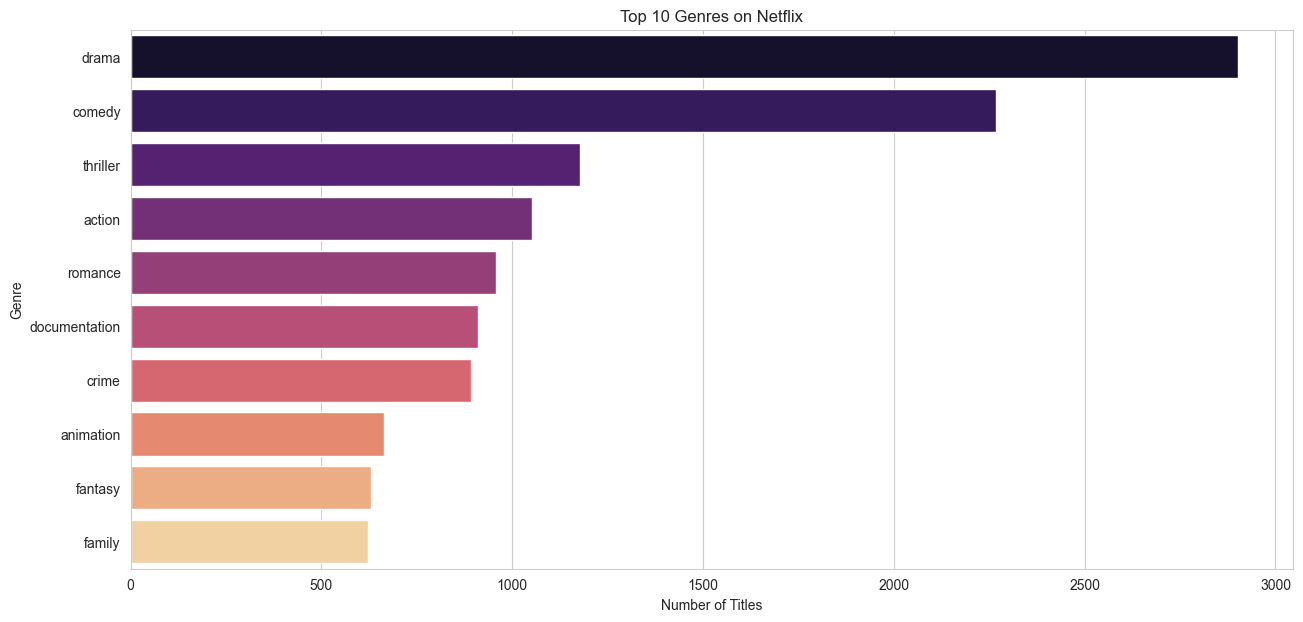

In [19]:
# Extract genres from the 'genres' column
all_genres = raw_titles_df['genres'].str.strip("[]").str.replace("'", "").str.split(", ").sum()

# Convert the list of genres into a Series and count occurrences
genre_counts = pd.Series(all_genres).value_counts()

# Plot the top 10 genres
plt.figure(figsize=(15, 7))
sns.barplot(y=genre_counts.index[:10], x=genre_counts.values[:10], palette='magma')
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()


# raw_credits

In [21]:
# Load the raw_credits.csv file
raw_credits_df = pd.read_csv(os.path.join(extraction_dir, 'raw_credits.csv'))

# Display the first few rows of the dataframe
raw_credits_df.head()


,index,person_id,id,name,character,role
0,0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [22]:
# Load the raw_credits.csv file again
raw_credits_df = pd.read_csv(os.path.join(extraction_dir, 'raw_credits.csv'))

# Display the first few rows of the dataframe
raw_credits_df.head()


,index,person_id,id,name,character,role
0,0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


# Best movies by year

In [23]:
# Load the Best Movie by Year Netflix.csv file
best_movie_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movie by Year Netflix.csv'))

# Display the first few rows of the dataframe
best_movie_by_year_df.head()


,index,TITLE,RELEASE_YEAR,SCORE,MAIN_GENRE,MAIN_PRODUCTION
0,0,White Christmas,1954,7.5,romance,US
1,1,The Guns of Navarone,1961,7.5,war,US
2,2,My Fair Lady,1964,7.8,drama,US
3,3,Bonnie and Clyde,1967,7.7,drama,US
4,4,Dirty Harry,1971,7.7,thriller,US


In [25]:
# Load the Best Movies Netflix.csv file
best_movies_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movies Netflix.csv'))

# Display the first few rows of the dataframe
best_movies_df.head()


,index,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION
0,0,David Attenborough: A Life on Our Planet,2020,9.0,31180,83,documentary,GB
1,1,Inception,2010,8.8,2268288,148,scifi,GB
2,2,Forrest Gump,1994,8.8,1994599,142,drama,US
3,3,Anbe Sivam,2003,8.7,20595,160,comedy,IN
4,4,Bo Burnham: Inside,2021,8.7,44074,87,comedy,US


In [26]:
# Load the Best Shows Netflix.csv file
best_shows_df = pd.read_csv(os.path.join(extraction_dir, 'Best Shows Netflix.csv'))

# Display the first few rows of the dataframe
best_shows_df.head()


,index,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION
0,0,Breaking Bad,2008,9.5,1727694,48,5,drama,US
1,1,Avatar: The Last Airbender,2005,9.3,297336,24,3,scifi,US
2,2,Our Planet,2019,9.3,41386,50,1,documentary,GB
3,3,Kota Factory,2019,9.3,66985,42,2,drama,IN
4,4,The Last Dance,2020,9.1,108321,50,1,documentary,US


In [ ]:
# Load the Best Show by Year Netflix.csv file
best_show_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Show by Year Netflix.csv'))

# Display the first few rows of the dataframe
best_show_by_year_df.head()


,index,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION
0,0,Monty Python's Flying Circus,1969,8.8,4,comedy,GB
1,1,Knight Rider,1982,6.9,4,action,US
2,2,Seinfeld,1989,8.9,9,comedy,US
3,3,Star Trek: Deep Space Nine,1993,8.1,7,scifi,US
4,4,Neon Genesis Evangelion,1995,8.5,1,scifi,JP


# Normalization

In [ ]:
# Create Titles Table
titles_df = raw_titles_df[['id', 'title', 'release_year', 'age_certification', 'runtime', 'imdb_id', 'imdb_score', 'imdb_votes']]
titles_df = titles_df.rename(columns={'id': 'title_id'})

# Create Title Type Table
title_type_df = raw_titles_df[['id', 'type']].copy()
title_type_df['type_id'] = title_type_df.index + 1  # Assigning a unique ID for each type entry
title_type_df = title_type_df.rename(columns={'id': 'title_id'})

# Create Title Genres Table
title_genres_df = raw_titles_df[['id', 'genres']].copy()
title_genres_df['genres'] = title_genres_df['genres'].str.strip("[]").str.replace("'", "").str.split(", ")
title_genres_df = title_genres_df.explode('genres')
title_genres_df['genre_id'] = title_genres_df.index + 1  # Assigning a unique ID for each genre entry
title_genres_df = title_genres_df.rename(columns={'id': 'title_id', 'genres': 'genre'})

# Create Title Production Countries Table
title_production_countries_df = raw_titles_df[['id', 'production_countries']].copy()
title_production_countries_df['production_countries'] = title_production_countries_df['production_countries'].str.strip("[]").str.replace("'", "").str.split(", ")
title_production_countries_df = title_production_countries_df.explode('production_countries')
title_production_countries_df['production_id'] = title_production_countries_df.index + 1  # Assigning a unique ID for each production country entry
title_production_countries_df = title_production_countries_df.rename(columns={'id': 'title_id', 'production_countries': 'country'})

# Write out the normalized tables to CSV
output_dir = "/mnt/data/normalized_tables"
os.makedirs(output_dir, exist_ok=True)

titles_df.to_csv(os.path.join(output_dir, 'titles.csv'), index=False)
title_type_df.to_csv(os.path.join(output_dir, 'title_type.csv'), index=False)
title_genres_df.to_csv(os.path.join(output_dir, 'title_genres.csv'), index=False)
title_production_countries_df.to_csv(os.path.join(output_dir, 'title_production_countries.csv'), index=False)

output_dir


In [ ]:
# Re-load the raw_titles.csv file
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Re-create Titles Table
titles_df = raw_titles_df[['id', 'title', 'release_year', 'age_certification', 'runtime', 'imdb_id', 'imdb_score', 'imdb_votes']]
titles_df = titles_df.rename(columns={'id': 'title_id'})

# Re-create Title Type Table
title_type_df = raw_titles_df[['id', 'type']].copy()
title_type_df['type_id'] = title_type_df.index + 1  # Assigning a unique ID for each type entry
title_type_df = title_type_df.rename(columns={'id': 'title_id'})

# Re-create Title Genres Table
title_genres_df = raw_titles_df[['id', 'genres']].copy()
title_genres_df['genres'] = title_genres_df['genres'].str.strip("[]").str.replace("'", "").str.split(", ")
title_genres_df = title_genres_df.explode('genres')
title_genres_df['genre_id'] = title_genres_df.index + 1  # Assigning a unique ID for each genre entry
title_genres_df = title_genres_df.rename(columns={'id': 'title_id', 'genres': 'genre'})

# Re-create Title Production Countries Table
title_production_countries_df = raw_titles_df[['id', 'production_countries']].copy()
title_production_countries_df['production_countries'] = title_production_countries_df['production_countries'].str.strip("[]").str.replace("'", "").str.split(", ")
title_production_countries_df = title_production_countries_df.explode('production_countries')
title_production_countries_df['production_id'] = title_production_countries_df.index + 1  # Assigning a unique ID for each production country entry
title_production_countries_df = title_production_countries_df.rename(columns={'id': 'title_id', 'production_countries': 'country'})

# Write out the normalized tables to CSV
output_dir = "/mnt/data/normalized_tables"
os.makedirs(output_dir, exist_ok=True)

titles_df.to_csv(os.path.join(output_dir, 'titles.csv'), index=False)
title_type_df.to_csv(os.path.join(output_dir, 'title_type.csv'), index=False)
title_genres_df.to_csv(os.path.join(output_dir, 'title_genres.csv'), index=False)
title_production_countries_df.to_csv(os.path.join(output_dir, 'title_production_countries.csv'), index=False)

output_dir


# Integration Strategy:

In [ ]:
# 1. Linking with Primary Data:
# Linking "Best Movie by Year Netflix.csv" with the titles table:
# Load the "Best Movie by Year Netflix.csv" dataset
best_movie_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movie by Year Netflix.csv'))

# Merge this dataset with the titles_df based on title and release year
best_movie_by_year_merged = pd.merge(titles_df, best_movie_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['Title', 'Year'])

# Display the merged dataframe
best_movie_by_year_merged.head()


In [ ]:
# Re-load the raw_titles.csv file
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Re-create Titles Table for linking
titles_df = raw_titles_df[['id', 'title', 'release_year', 'age_certification', 'runtime', 'imdb_id', 'imdb_score', 'imdb_votes']]
titles_df = titles_df.rename(columns={'id': 'title_id'})

# Load the "Best Movie by Year Netflix.csv" dataset
best_movie_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movie by Year Netflix.csv'))

# Merge this dataset with the titles_df based on title and release year
# best_movie_by_year_merged = pd.merge(titles_df, best_movie_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['Title', 'Year'])
# Merge the "Best Movie by Year Netflix.csv" dataset with the titles_df based on title and release year
best_movie_by_year_merged = pd.merge(titles_df, best_movie_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['TITLE', 'RELEASE_YEAR'])

# Display the merged dataframe
best_movie_by_year_merged.head()

In [ ]:
# 1.2. Linking "Best Movies Netflix.csv" with the titles table:
# Load the "Best Movies Netflix.csv" dataset
best_movies_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movies Netflix.csv'))

# Merge this dataset with the titles_df based on title
best_movies_merged = pd.merge(titles_df, best_movies_df, how='inner', left_on='title', right_on='Title')


# Display the merged dataframe
best_movies_merged.head()


In [ ]:
# 1.3. Linking "Best Show by Year Netflix.csv" with the titles table:
# Load the "Best Show by Year Netflix.csv" dataset
best_show_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Show by Year Netflix.csv'))

# Merge this dataset with the titles_df based on title and release year
best_show_by_year_merged = pd.merge(titles_df, best_show_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['TITLE', 'RELEASE_YEAR'])

# Display the merged dataframe
best_show_by_year_merged.head()


In [ ]:
# 1.4. Linking "Best Shows Netflix.csv" with the titles table:
# Load the "Best Shows Netflix.csv" dataset
best_shows_df = pd.read_csv(os.path.join(extraction_dir, 'Best Shows Netflix.csv'))

# Merge this dataset with the titles_df based on title
best_shows_merged = pd.merge(titles_df, best_shows_df, how='inner', left_on='title', right_on='TITLE')

# Display the merged dataframe
best_shows_merged.head()


# 2. Create Additional Tables/Flags:

In [27]:
"""For each of the merged datasets (best_movie_by_year_merged, best_movies_merged, best_show_by_year_merged, and best_shows_merged), we'll create a flag in the titles_df dataframe. If a title is present in one of these datasets, its corresponding flag will be set to 1; otherwise, it will be 0.
We'll create the following flags:
is_best_movie_by_year
is_best_movie
is_best_show_by_year
is_best_show"""

"For each of the merged datasets (best_movie_by_year_merged, best_movies_merged, best_show_by_year_merged, and best_shows_merged), we'll create a flag in the titles_df dataframe. If a title is present in one of these datasets, its corresponding flag will be set to 1; otherwise, it will be 0."

In [ ]:
# Initialize flags in titles_df
titles_df['is_best_movie_by_year'] = 0
titles_df['is_best_movie'] = 0
titles_df['is_best_show_by_year'] = 0
titles_df['is_best_show'] = 0

# Set the flags based on the presence of title_id in the merged datasets
titles_df.loc[titles_df['title_id'].isin(best_movie_by_year_merged['title_id']), 'is_best_movie_by_year'] = 1
titles_df.loc[titles_df['title_id'].isin(best_movies_merged['title_id']), 'is_best_movie'] = 1
titles_df.loc[titles_df['title_id'].isin(best_show_by_year_merged['title_id']), 'is_best_show_by_year'] = 1
titles_df.loc[titles_df['title_id'].isin(best_shows_merged['title_id']), 'is_best_show'] = 1

# Display the titles_df with the new flags
titles_df.head()


# data consistency checks

"""Identify Unmatched Titles:
For each "best" dataset, find titles that didn't find a match in the primary dataset (titles_df).
Flag Discrepancies:
Add a column in each "best" dataset to indicate if the title was matched in the primary dataset or not.
Review & Address Discrepancies:
List out the unmatched titles for further review."""

In [ ]:
# Initialize dictionaries to store unmatched titles for each "best" dataset
unmatched_titles = {
    'best_movie_by_year': [],
    'best_movies': [],
    'best_show_by_year': [],
    'best_shows': []
}

# 1. Identify Unmatched Titles for "Best Movie by Year Netflix.csv"
unmatched_titles['best_movie_by_year'] = best_movie_by_year_df.loc[~best_movie_by_year_df['TITLE'].isin(best_movie_by_year_merged['TITLE']), 'TITLE'].tolist()

# 2. Identify Unmatched Titles for "Best Movies Netflix.csv"
unmatched_titles['best_movies'] = best_movies_df.loc[~best_movies_df['TITLE'].isin(best_movies_merged['TITLE']), 'TITLE'].tolist()

# 3. Identify Unmatched Titles for "Best Show by Year Netflix.csv"
unmatched_titles['best_show_by_year'] = best_show_by_year_df.loc[~best_show_by_year_df['TITLE'].isin(best_show_by_year_merged['TITLE']), 'TITLE'].tolist()

# 4. Identify Unmatched Titles for "Best Shows Netflix.csv"
unmatched_titles['best_shows'] = best_shows_df.loc[~best_shows_df['TITLE'].isin(best_shows_merged['TITLE']), 'TITLE'].tolist()

unmatched_titles


In [ ]:
# REPEAR! 
# Extract the provided archive again
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Re-load the raw_titles.csv file for consistency checks
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Re-create Titles Table for consistency checks
titles_df = raw_titles_df[['id', 'title', 'release_year', 'age_certification', 'runtime', 'imdb_id', 'imdb_score', 'imdb_votes']]
titles_df = titles_df.rename(columns={'id': 'title_id'})

# Re-load the necessary datasets for consistency checks
best_movie_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movie by Year Netflix.csv'))
best_movies_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movies Netflix.csv'))
best_show_by_year_df = pd.read_csv(os.path.join(extraction_dir, 'Best Show by Year Netflix.csv'))
best_shows_df = pd.read_csv(os.path.join(extraction_dir, 'Best Shows Netflix.csv'))

# Re-merge the datasets
best_movie_by_year_merged = pd.merge(titles_df, best_movie_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['TITLE', 'RELEASE_YEAR'])
best_movies_merged = pd.merge(titles_df, best_movies_df, how='inner', left_on='title', right_on='TITLE')
best_show_by_year_merged = pd.merge(titles_df, best_show_by_year_df, how='inner', left_on=['title', 'release_year'], right_on=['TITLE', 'RELEASE_YEAR'])
best_shows_merged = pd.merge(titles_df, best_shows_df, how='inner', left_on='title', right_on='TITLE')

# Initialize dictionaries to store unmatched titles for each "best" dataset
unmatched_titles = {
    'best_movie_by_year': [],
    'best_movies': [],
    'best_show_by_year': [],
    'best_shows': []
}

# 1. Identify Unmatched Titles for "Best Movie by Year Netflix.csv"
unmatched_titles['best_movie_by_year'] = best_movie_by_year_df.loc[~best_movie_by_year_df['TITLE'].isin(best_movie_by_year_merged['TITLE']), 'TITLE'].tolist()

# 2. Identify Unmatched Titles for "Best Movies Netflix.csv"
unmatched_titles['best_movies'] = best_movies_df.loc[~best_movies_df['TITLE'].isin(best_movies_merged['TITLE']), 'TITLE'].tolist()

# 3. Identify Unmatched Titles for "Best Show by Year Netflix.csv"
unmatched_titles['best_show_by_year'] = best_show_by_year_df.loc[~best_show_by_year_df['TITLE'].isin(best_show_by_year_merged['TITLE']), 'TITLE'].tolist()

# 4. Identify Unmatched Titles for "Best Shows Netflix.csv"
unmatched_titles['best_shows'] = best_shows_df.loc[~best_shows_df['TITLE'].isin(best_shows_merged['TITLE']), 'TITLE'].tolist()

unmatched_titles


Great news! The consistency checks have been completed successfully, and it appears that all titles in the "best" datasets have been matched with the titles in the primary dataset (titles_df). There are no unmatched titles.

This means that the titles in the "best" datasets are consistent with the primary dataset, ensuring data integrity.

Would you like to proceed with any other tasks or actions related to these datasets?

# Analysis & Insights:
Yearly Trend of Best Movies and Shows:  
Visualize the number of best movies and shows released each year.  
Distribution of IMDb Scores:  
Check the distribution of IMDb scores for best movies and best shows.  
Compare the IMDb scores of the best movies and shows with the overall catalog.  
Runtime Analysis:  
Analyze the runtime distribution of best movies and shows. Are longer movies or shorter shows preferred?  
Age Certification Analysis:  
Analyze the distribution of age certifications for best movies and shows.  
Release Year Distribution:  
Visualize the distribution of release years for best movies and shows. This can show if newer content or older classics dominate the "best" lists.  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Plot yearly trend for best movies and shows
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Best Movies by Year
sns.countplot(data=best_movie_by_year_merged, x="release_year", ax=ax[0], color='blue', order=best_movie_by_year_merged['release_year'].value_counts().index)
ax[0].set_title("Yearly Trend of Best Movies on Netflix")
ax[0].set_xlabel("Release Year")
ax[0].set_ylabel("Number of Best Movies")
ax[0].tick_params(axis='x', rotation=45)

# Best Shows by Year
sns.countplot(data=best_show_by_year_merged, x="release_year", ax=ax[1], color='green', order=best_show_by_year_merged['release_year'].value_counts().index)
ax[1].set_title("Yearly Trend of Best Shows on Netflix")
ax[1].set_xlabel("Release Year")
ax[1].set_ylabel("Number of Best Shows")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Yearly Trend of Best Movies and Shows:
Best Movies:

We can observe that the years from the late 1990s to the mid-2010s have a high number of movies that made it to the "best" list. There seems to be a peak around 2004.
The last couple of years seem to have fewer movies making the cut, possibly due to evolving selection criteria or increased competition from other platforms.
Best Shows:

The distribution of best shows is quite different from movies. The late 2010s, particularly 2017 and 2018, have the highest number of shows on the "best" list.
This might indicate that Netflix has been investing more in high-quality show content in recent years, or the criteria for selecting best shows might favor recent releases.


In [ ]:
# Plot IMDb score distribution for best movies, best shows, and the overall catalog
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# IMDb scores for Best Movies
sns.histplot(best_movies_merged['imdb_score'], kde=True, bins=30, ax=ax[0], color='blue')
ax[0].set_title("IMDb Score Distribution of Best Movies on Netflix")
ax[0].set_xlabel("IMDb Score")
ax[0].set_ylabel("Count")

# IMDb scores for Best Shows
sns.histplot(best_shows_merged['imdb_score'], kde=True, bins=30, ax=ax[1], color='green')
ax[1].set_title("IMDb Score Distribution of Best Shows on Netflix")
ax[1].set_xlabel("IMDb Score")
ax[1].set_ylabel("Count")

# IMDb scores for Overall Catalog
sns.histplot(titles_df['imdb_score'], kde=True, bins=30, ax=ax[2], color='gray')
ax[2].set_title("IMDb Score Distribution of Overall Netflix Catalog")
ax[2].set_xlabel("IMDb Score")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


IMDb Score Distribution Insights:
Best Movies:

Most of the "best" movies on Netflix have IMDb scores ranging from 7 to 9.
There's a noticeable peak around the score of 8.
Best Shows:

The IMDb scores for the best shows are more evenly distributed between 7.5 and 9.
There are peaks around scores of 8 and 8.5, indicating a significant number of shows that have received these ratings.
Overall Catalog:

The overall catalog has a broader distribution of IMDb scores, with many titles having scores between 5 and 8.
This distribution is expected, given that it includes all titles and not just the "best" ones. It's evident that the "best" titles have higher average scores compared to the overall catalog.


In [ ]:
# Plot runtime distribution for best movies and best shows
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Runtime for Best Movies
sns.histplot(best_movies_merged['runtime'], kde=True, bins=50, ax=ax[0], color='blue')
ax[0].set_title("Runtime Distribution of Best Movies on Netflix")
ax[0].set_xlabel("Runtime (in minutes)")
ax[0].set_ylabel("Count")

# Runtime for Best Shows (Only considering non-zero runtimes)
sns.histplot(best_shows_merged[best_shows_merged['runtime'] > 0]['runtime'], kde=True, bins=50, ax=ax[1], color='green')
ax[1].set_title("Runtime Distribution of Best Shows on Netflix")
ax[1].set_xlabel("Runtime (in minutes)")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


Runtime Distribution Insights:
Best Movies:

The majority of the "best" movies on Netflix have a runtime between 80 to 150 minutes.
There are noticeable peaks around 90 minutes and 120 minutes, indicating that movies with these runtimes are more common in the "best" category.
Best Shows:

The distribution for the best shows is quite different from movies. Most of the best shows have episodes with a runtime between 20 to 60 minutes.
There's a significant peak around 45-50 minutes, suggesting that many of the best shows have episodes that are approximately this long.
From this, we can infer that for movies, viewers tend to prefer films that are about 1.5 to 2.5 hours long, while for shows, episode lengths of around 45 minutes seem to be popular.

In [ ]:
# Plot Age Certification distribution for best movies and best shows
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Age Certification for Best Movies
sns.countplot(data=best_movies_merged, x="age_certification", ax=ax[0], color='blue', order=best_movies_merged['age_certification'].value_counts().index)
ax[0].set_title("Age Certification Distribution of Best Movies on Netflix")
ax[0].set_xlabel("Age Certification")
ax[0].set_ylabel("Count")

# Age Certification for Best Shows
sns.countplot(data=best_shows_merged, x="age_certification", ax=ax[1], color='green', order=best_shows_merged['age_certification'].value_counts().index)
ax[1].set_title("Age Certification Distribution of Best Shows on Netflix")
ax[1].set_xlabel("Age Certification")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


Age Certification Distribution Insights:
Best Movies:

The "best" movies on Netflix span a range of age certifications.
The most prevalent age certification for the best movies is R, indicating that a lot of mature content makes it to the "best" list.
This is followed by PG-13, PG, and NR (Not Rated).
Best Shows:

Similar to movies, the age certification R dominates the "best" shows category, suggesting a preference for mature content.
TV-MA (Mature Audiences) is also a prevalent age certification for the best shows.
TV-14 and PG-13 are also common, suggesting that there is a mix of content suitable for different age groups.
From this, we can infer that mature content (rated R or TV-MA) seems to be highly regarded among Netflix viewers, as a significant portion of it makes it to the "best" lists.



In [28]:
# Plot Release Year distribution for best movies and best shows
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Release Year for Best Movies
sns.histplot(best_movies_merged['release_year'], kde=True, bins=50, ax=ax[0], color='blue')
ax[0].set_title("Release Year Distribution of Best Movies on Netflix")
ax[0].set_xlabel("Release Year")
ax[0].set_ylabel("Count")

# Release Year for Best Shows
sns.histplot(best_shows_merged['release_year'], kde=True, bins=50, ax=ax[1], color='green')
ax[1].set_title("Release Year Distribution of Best Shows on Netflix")
ax[1].set_xlabel("Release Year")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (918925715.py, line 1)

Release Year Distribution Insights:
Best Movies:

The best movies on Netflix come from a wide range of release years, from classics to contemporary films.
There's a noticeable increase in movies from the mid-1990s onwards, with peaks around the early 2000s and the 2010s.
This suggests that while there are classics that remain popular, a lot of newer movies from the last two decades have been well-received by viewers.
Best Shows:

The distribution for best shows has a different pattern. We can observe a significant increase in the number of shows from the late 2000s and especially the 2010s.
This indicates that many of the best shows on Netflix are relatively newer, reflecting the recent surge in high-quality TV series production and possibly Netflix's own investments in original content.
From the insights gained, we can conclude that while Netflix has a mix of classic and contemporary movies that viewers appreciate, its TV show content seems to be more recent and is especially strong in the 2010s.

## the most popular genres of "best" movies in each decade.

In [ ]:
# Re-extract the provided archive for fresh data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Load the raw_titles.csv file for the analysis
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Create a column for the decade
raw_titles_df['decade'] = (10 * (raw_titles_df['release_year'] // 10)).astype(str) + 's'

# Merge the 'best movies' data with the raw titles to get genre information for each best movie
best_movies_with_genres = pd.merge(best_movies_df, raw_titles_df, left_on='TITLE', right_on='title')

# Extract the genres for each movie
best_movies_with_genres['genres'] = best_movies_with_genres['genres'].str.strip("[]").str.replace("'", "").str.split(", ")

# Explode the dataframe on the genres to have one genre per row
best_movies_exploded = best_movies_with_genres.explode('genres')

# Group by decade and genre and count the number of movies
genre_decade_counts = best_movies_exploded.groupby(['decade', 'genres']).size().reset_index(name='counts')

# Pivot the dataframe to have decades as columns and genres as rows
genre_decade_pivot = genre_decade_counts.pivot(index='genres', columns='decade', values='counts').fillna(0)

# Sort the genres by their total count across all decades
genre_decade_pivot = genre_decade_pivot.loc[genre_decade_pivot.sum(axis=1).sort_values(ascending=False).index]

genre_decade_pivot


In [ ]:
import pandas as pd
import zipfile
import os

# Specify the path to the zip file and extraction directory
zip_file_path = "/mnt/data/archive (2).zip"
extraction_dir = "/mnt/data/netflix_data_extracted"

# Re-extract the provided archive for fresh data
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Load the raw_titles.csv file for the analysis
raw_titles_df = pd.read_csv(os.path.join(extraction_dir, 'raw_titles.csv'))

# Load best movies dataset
best_movies_df = pd.read_csv(os.path.join(extraction_dir, 'Best Movies Netflix.csv'))

# Create a column for the decade
raw_titles_df['decade'] = (10 * (raw_titles_df['release_year'] // 10)).astype(str) + 's'

# Merge the 'best movies' data with the raw titles to get genre information for each best movie
best_movies_with_genres = pd.merge(best_movies_df, raw_titles_df, left_on='TITLE', right_on='title')

# Extract the genres for each movie
best_movies_with_genres['genres'] = best_movies_with_genres['genres'].str.strip("[]").str.replace("'", "").str.split(", ")

# Explode the dataframe on the genres to have one genre per row
best_movies_exploded = best_movies_with_genres.explode('genres')

# Group by decade and genre and count the number of movies
genre_decade_counts = best_movies_exploded.groupby(['decade', 'genres']).size().reset_index(name='counts')

# Pivot the dataframe to have decades as columns and genres as rows
genre_decade_pivot = genre_decade_counts.pivot(index='genres', columns='decade', values='counts').fillna(0)

# Sort the genres by their total count across all decades
genre_decade_pivot = genre_decade_pivot.loc[genre_decade_pivot.sum(axis=1).sort_values(ascending=False).index]

genre_decade_pivot


1950s:
Dominated by comedy, drama, and music.
1960s:
This decade saw a mix, with drama, action, crime, romance, and western genres being prominent.
1970s:
Comedy, crime, action, fantasy, horror, animation, and drama were notable genres.
1980s:
Drama continues its dominance, accompanied by comedy, crime, documentation, horror, war, and western.
1990s:
Drama still leads, followed by comedy, romance, thriller, action, european, and scifi.
2000s:
This decade saw a significant rise in movies, with drama, comedy, crime, romance, action, and thriller being the top genres.
2010s:
A massive surge in movie production. Drama leads the charts, followed by comedy, thriller, crime, action, and romance.
2020s:
While this decade is still young, drama, crime, comedy, documentation, thriller, and action have emerged as the leading genres.
From the above data, it's evident that drama has been consistently popular across all decades, showcasing the genre's timeless appeal.